# Application of machine learning algorithms to GRS data in Python

By Tom Sander

## Import packages

In [1]:
import polars as pl
import matplotlib.pyplot as plt

## Load data

In [2]:
def load_lpgrs_tab(filepath: str) -> pl.DataFrame:
    """Loads a Lunar Prospector GRS .tab file into a Polars DataFrame. Handles wrapped lines, multiple-space delimiters, and scientific notation.

    Args:
        filepath (str): Path to the .tab file.

    Returns:
        pl.DataFrame: DataFrame containing the GRS data with appropriate column names.
    """
    # 1. Read all whitespace-separated tokens (NASA records are often wrapped)
    with open(filepath, 'r') as f:
        tokens = f.read().split()
    
    # 2. Reshape into 61 columns (the standard format for GRS abundance files)
    # There are roughly 1,300 records in a 5-degree file
    record_width = 61
    rows = [tokens[i : i + record_width] for i in range(0, len(tokens), record_width)]
    
    # 3. Create the DataFrame and cast Scientific Notation to Floats
    df = pl.DataFrame(rows, orient="row").select([
        pl.all().cast(pl.Float64)
    ])
    
    # 4. Map the first 16 columns to their scientific names
    names = [
        "bin_index", "lat_start", "lat_end", "lon_start", "lon_end",
        "thorium", "th_err", "potassium", "k_err", "iron", "fe_err",
        "titanium", "ti_err", "samarium", "sm_err", "calcium"
    ]
    
    # Select only the 16 columns you need and rename them
    return df.select(df.columns[:16]).rename({old: new for old, new in zip(df.columns[:16], names)})

In [3]:
# Define paths to data files
path_to_tab = "data/lpgrs_high1_elem_abundance_5deg.tab"
path_to_lbl = "data/lpgrs_high1_elem_abundance_5deg.lbl"
path_to_xml = "data/lpgrs_high1_elem_abundance_5deg.xml"

# Read the .tab file using Polars
df = load_lpgrs_tab(path_to_tab)

## Normalization

### 2. Data Preparation
Machine learning models are sensitive to `"dirty"` data. Before we begin, we must ensure our dataset is clean.

We will filter our dataset to keep only the columns relevant to geochemistry. We specifically exclude Latitude and Longitude from the training data because we want the model to group pixels based on composition and not their physical location.

In [4]:
# Define the geochemical features we want to analyze
feature_cols = ['iron', 'titanium', 'thorium', 'potassium']

# Drop rows where any of these values are null to prevent errors
df_clean = df.drop_nulls(subset=feature_cols)

print(f"Original dataset size: {df.height} rows")
print(f"Clean dataset size: {df_clean.height} rows")

Original dataset size: 1790 rows
Clean dataset size: 1790 rows


### 3. Standardization (The "Apples to Oranges" Problem)
Geochemical data often comes in mixed units. Iron (Fe) is usually measured in weight percent (`0` to `20 wt%`), while Thorium (Th) is measured in parts per million (`0` to `15 ppm`).

If we do not normalize this data, the algorithm will be biased. It will think Iron is "more important" simply because the numbers are larger. We use `StandardScaler` to force all elements onto a level playing field where they have a mean of 0 and a variance of 1.

In [5]:
from sklearn.preprocessing import StandardScaler

# Convert the Polars columns to a NumPy array for Scikit-Learn
X_raw = df_clean.select(feature_cols).to_numpy()

# Initialize the Scaler
scaler = StandardScaler()

# Fit and Transform the data
X_scaled = scaler.fit_transform(X_raw)

print("Data standardization complete.")
print(f"Example raw Fe value: {X_raw[0][0]}")
print(f"Example scaled Fe value: {X_scaled[0][0]:.4f}")

Data standardization complete.
Example raw Fe value: 0.44507
Example scaled Fe value: 0.3745


### 4. The Elbow Method
How many distinct terranes exist on the Moon? Instead of guessing, we use the "Elbow Method."

We run the K-Means algorithm multiple times with a different number of clusters (k) each time. We calculate the "Inertia" for every run. Inertia measures how tightly grouped the clusters are. We look for the "elbow" in the curve where adding more clusters provides diminishing returns.

Running Elbow Method test...


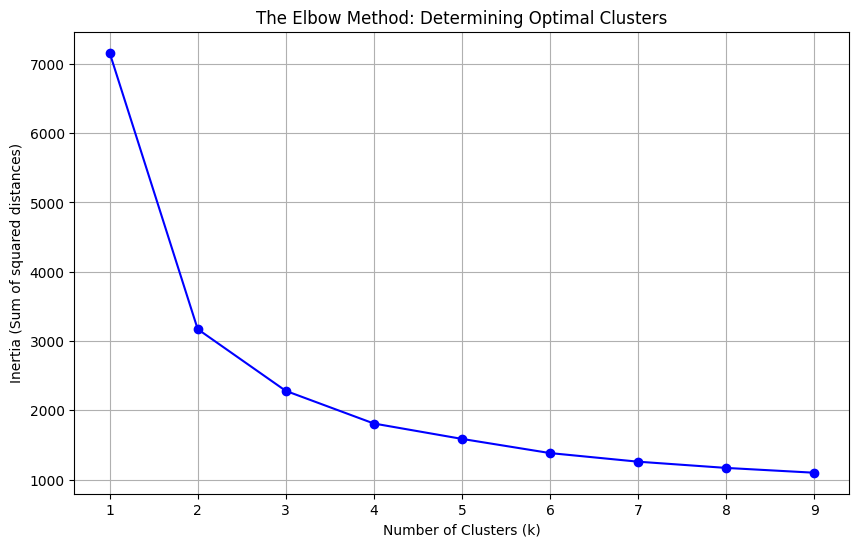

In [6]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 10)

print("Running Elbow Method test...")

for k in k_range:
    # Run KMeans for k clusters
    # n_init=10 means it runs 10 times with different starting seeds to find the best result
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertia.append(kmeans_temp.inertia_)

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('The Elbow Method: Determining Optimal Clusters')
plt.grid(True)
plt.show()